In [1]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
from tqdm import tqdm

In [2]:
data_file = r'data/drenagem.zip'
gdf = gpd.read_file(data_file)

<Axes: >

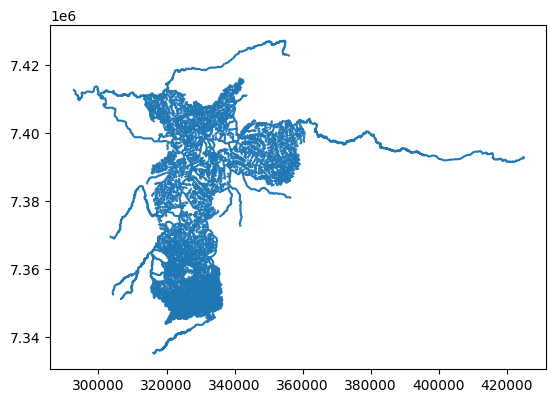

In [3]:
gdf.plot()

In [4]:
gdf.head()

cd_identif cd_tipo_ac tx_tipo_ac cd_numero_ nm_bairro           nm_acident  \
0         1.0         ND       None          1      None                   SD   
1     26125.0         ND       None          2      None                   SD   
2         2.0         ND       None          0      None                   SD   
3     26126.0        COR    CORREGO          0      None  CORREGO PIRARUNGAUA   
4     26127.0         ND       None          1      None                   SD   

   qt_comprim  cd_tipo_cu                     nm_tipo_cu nm_via_pro  \
0  221.400887        11.0       Trecho em estado natural       None   
1  352.657947        11.0       Trecho em estado natural       None   
2  170.328879        11.0       Trecho em estado natural       None   
3  547.533144        10.0  Trecho canalizado subterrâneo       None   
4  173.878000        11.0       Trecho em estado natural       None   

            nm_descrit           nm_tipo_tr dt_atualiz cd_usuario  \
0                 None  Trecho a céu aberto 2025-01-03       None   
1                 None  Trecho a céu aberto 2025-01-03       None   
2                 None  Trecho a céu aberto 2025-01-03       None   
3  Córrego Pirarungáua       Trecho fechado 2025-01-03       None   
4                 None  Trecho a céu aberto 2025-01-03       None   

                                            geometry  
0  LINESTRING (326392.101 7349046.69, 326389.141 ...  
1  LINESTRING (332064.747 7351146.304, 332068.988...  
2  LINESTRING (345321.612 7399298.312, 345324.559...  
3  LINESTRING (334512.87 7384823.742, 334492.215 ...  
4  LINESTRING (326591.932 7347739.889, 326615.702...

In [5]:
gdf = gdf[['nm_acident', 'geometry']]

In [6]:
nomes = gdf['nm_acident'].unique()

In [7]:
len(nomes)

329

In [8]:
gdf['nm_acident'].value_counts().head(10)

nm_acident
SD                    21944
RIO CAPIVARI            223
RIBEIRAO ITAQUERA       125
RIO EMBU-GUACU          119
RIO DOS MONOS           116
RIO TIETE               104
RIO ARICANDUVA           96
RIACHO DO IPIRANGA       78
RIO DOS CAMPOS           76
CORREGO PIRAJUCARA       68
Name: count, dtype: int64

In [9]:
for nome in tqdm(nomes):
    #excluindo sem denominação porque vai dar problema
    if nome != 'SD':
        segmentos = gdf[gdf['nm_acident'] == nome]
        if len(segmentos) < 2:
            continue
        segmentos['ponto_inicial'] = segmentos['geometry'].apply(lambda x: x.coords[0])
        segmentos['ponto_final'] = segmentos['geometry'].apply(lambda x: x.coords[-1])
        for i in range(len(segmentos)):
            pivot = segmentos.iloc[i]
            ponto = Point(pivot['ponto_final'])
            outros_segs= segmentos.drop(segmentos.index[i])
            pontos_iniciais_outros_segs = gpd.GeoDataFrame(geometry=outros_segs['ponto_final'].apply(Point))
            pontos_iniciais_outros_segs['distancias'] = outros_segs.geometry.distance(ponto)
            indice_mais_proximo = pontos_iniciais_outros_segs['distancias'].idxmin()
            #se a distancia for maior que 1000 metros, pula
            if pontos_iniciais_outros_segs['distancias'][indice_mais_proximo] > 500:
                continue
            seg_mais_proximo = outros_segs.loc[indice_mais_proximo]
            pivot = gpd.GeoSeries(pivot.geometry, crs=gdf.crs)
            menor_linha = pivot.shortest_line(seg_mais_proximo.geometry)
            linha_nova_df = gpd.GeoDataFrame({'nm_acident' : nome, 'geometry' : menor_linha},  crs=gdf.crs)
            gdf = pd.concat([gdf, linha_nova_df], ignore_index=True)


  0%|          | 0/329 [00:00<?, ?it/s]/home/h-pgy/projects/segmentos_rios_sp/venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1981: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/h-pgy/projects/segmentos_rios_sp/venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1981: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/h-pgy/projects/segmentos_rios_sp/venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1981: Se

In [10]:
gdf = gdf[gdf['nm_acident']!='SD']

In [11]:
gdf_final = gdf.dissolve('nm_acident')

<Axes: >

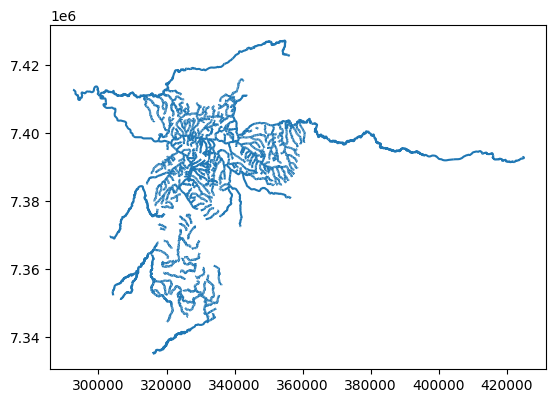

In [12]:
gdf_final.plot()

In [13]:
gdf_final.head()

geometry
nm_acident                                                                 
BRACO TIETE               MULTILINESTRING ((344122.748 7400452.749, 3440...
CANAL DE SANEAMENTO       MULTILINESTRING ((330469.032 7398269.542, 3304...
CORREGO ACLIMACAO         MULTILINESTRING ((333934.975 7392243.836, 3339...
CORREGO AGUA BRANCA       MULTILINESTRING ((327841.4 7398178.333, 327841...
CORREGO AGUA DOS BRANCOS  MULTILINESTRING ((319083.06 7381219.11, 319083...

In [14]:
gdf_final.geometry.type

nm_acident
BRACO TIETE                 MultiLineString
CANAL DE SANEAMENTO         MultiLineString
CORREGO ACLIMACAO           MultiLineString
CORREGO AGUA BRANCA         MultiLineString
CORREGO AGUA DOS BRANCOS    MultiLineString
                                 ...       
RIO PINHEIROS               MultiLineString
RIO TAMANDUATEI             MultiLineString
RIO TIETE                   MultiLineString
RIO VERDE                   MultiLineString
TUNEL MORINGUINHO           MultiLineString
Length: 328, dtype: object

In [15]:
gdf_final.explore()

In [16]:
from shapely.ops import linemerge
from shapely.geometry import MultiLineString, LineString

In [17]:
continuas = 0
for linha in gdf_final.geometry:
    if linha.geom_type == 'MultiLineString':
        try:
            merged = linemerge(linha)
            is_continua = isinstance(merged, LineString)
            if is_continua:
                continuas += 1
        except Exception as e:
            print(f"Erro ao mesclar linha: {linha}, erro: {e}")
            merged = linha
        

In [18]:
continuas/len(gdf_final.geometry)

0.9237804878048781